In [2]:
import os
from pfca import init_path
from pfca.visuals.img2D import imgplot

Current Working Directory: /Users/shwetankpanwar/Documents/BTPData/python_scripts/cmb_segmentation
The file structure creation failed. Structure already exists!


In [3]:
from pfca.visuals.plot3D import *

In [4]:
from pfca.core.preprocessing import *

In [5]:
from pfca.core.processing import *

In [6]:
from pfca import file_read as f
import ants

In [7]:
raw_dir, nifti_dir = init_path()
cur_path = os.getcwd()
patients_list = f.get_immediate_subdirectories(raw_dir)
patient = patients_list[0]

In [8]:
im_nifti = nifti_ANTS(nifti_dir, patient, category = 'eswan', unskulled = True)
im_patient = mni_template_registration(cur_path, im_nifti, patient)

In [9]:
#testing for template exclusion idea for anatomical exclusion to reduce search space
talariach = ants.image_read(cur_path + '/datasets/talairach.nii')
mni_t2 = ants.image_read(cur_path + '/datasets/mni_t2_template.nii')
harvard_atlas = ants.image_read(cur_path + '/datasets/harvard_atlas.nii')

In [10]:
talariach

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (141, 172, 110)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (70.0, 102.0, -42.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [11]:
im_patient

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [12]:
mni_t2

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [13]:
harvard_atlas

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [14]:
#Registering Harvard-Oxford Atlas with MNI-152 template using non-linear registration
harvard_mni = mni_template_registration(cur_path,harvard_atlas,'harvard')

In [15]:
harvard_mni

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

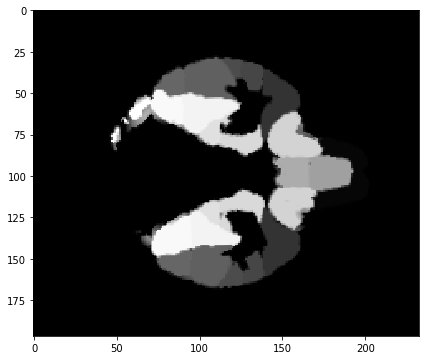

In [16]:
imgplot(harvard_mni, slice_no=[45])

In [17]:
#generating cortex mask from the atlas excluding all the regions of cerebrum 
harvard_mni_mask = ((harvard_mni.numpy()) > 0)*1

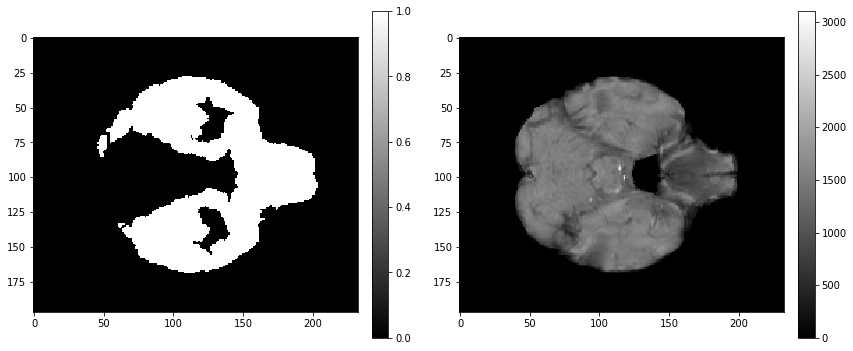

In [18]:
imgplot(harvard_mni_mask, im_patient, slice_no=[45,45])

In [19]:
cortex_regions = harvard_mni_mask * im_patient.numpy()

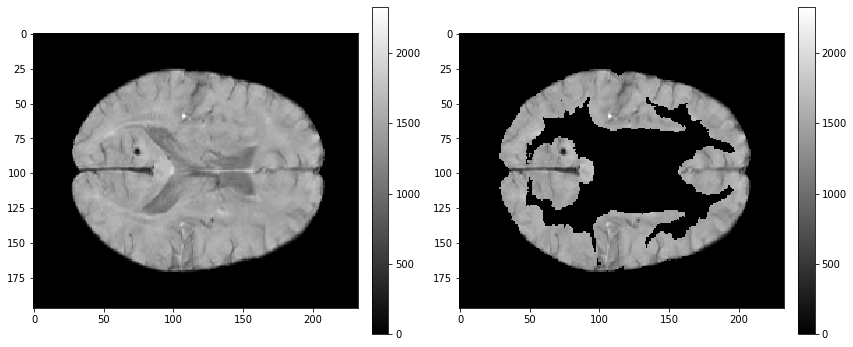

In [27]:
imgplot(im_patient, cortex_regions, slice_no=[85,85])

In [18]:
#Plot the cortex regions of the brain using the plot_brain function
plot_brain(cortex_regions)

In [20]:
#Calculating the rst output on the cortex image
rst_out = rst_3d(cortex_regions,2,2,0.2)

Time taken for 3D RST: 8.618027925491333


In [21]:
#calculating the RST output on the whole image
img_pat = im_patient.numpy()
rst_whole = rst_3d(img_pat, 2,2,0.2)

Time taken for 3D RST: 22.928712368011475


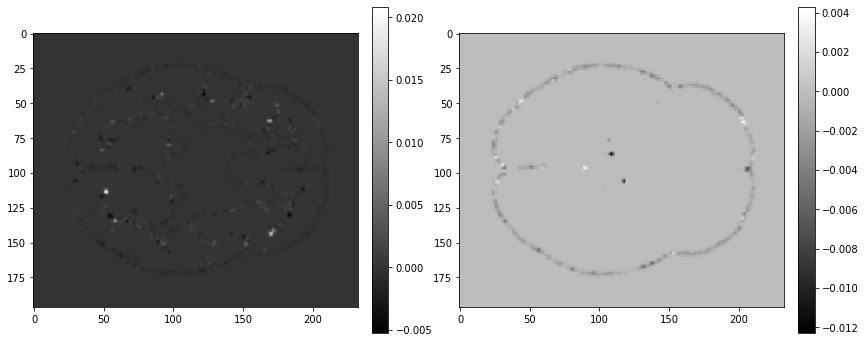

In [31]:
imgplot(rst_out,rst_whole,slice_no=[65,65])

In [32]:
#many false points are generated in the RST on the cortex image...so its better to apply mask on the rst_whole

In [22]:
rst_masked = rst_whole * harvard_mni_mask

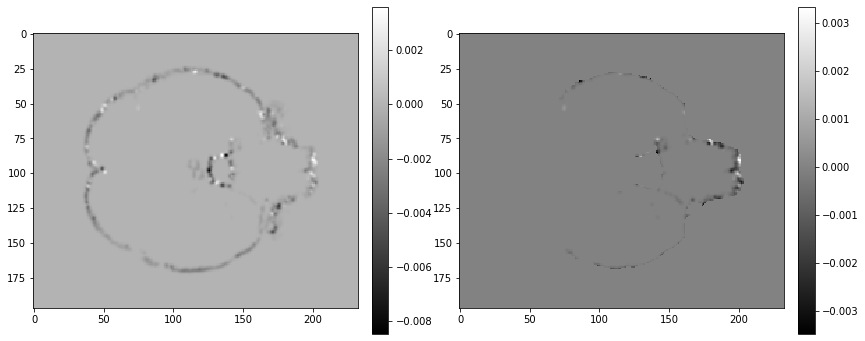

In [34]:
imgplot(rst_whole, rst_masked, slice_no=[45,45])

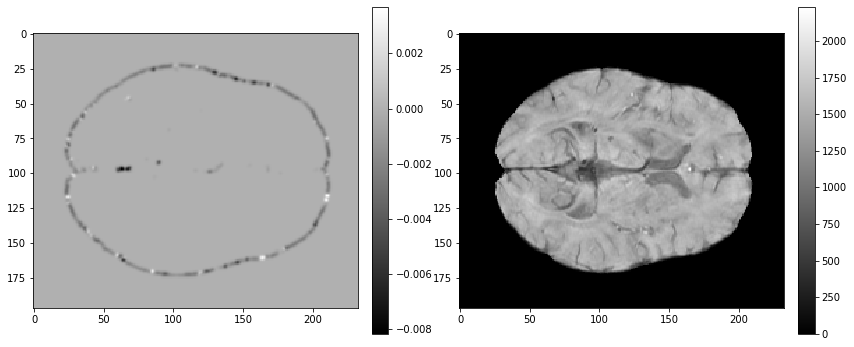

In [35]:
imgplot(rst_whole, img_pat, slice_no=[75,75])

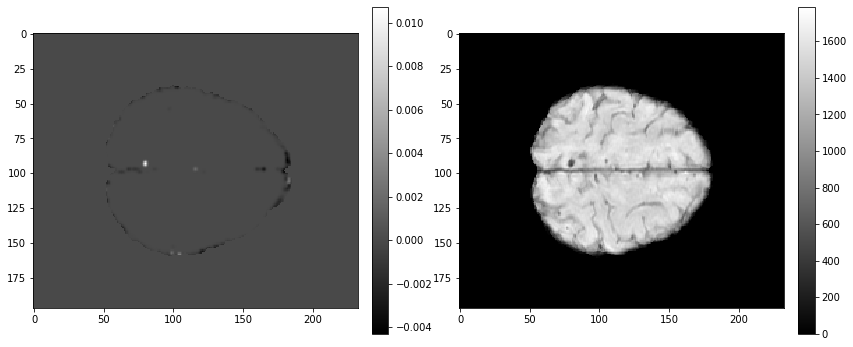

In [36]:
imgplot(rst_masked, img_pat, slice_no = [128,128])

In [23]:
#Extracting the candidate points from the RST output image
import skimage.feature as feature
from time import time
t1 = time()
peaks = feature.peak_local_max(rst_masked, min_distance=2,threshold_rel = 0.2)
t2 = time()
print("Time taken to find local maxima: " + str(t2-t1))

Time taken to find local maxima: 0.2290050983428955


In [24]:
peaks

array([[ 97,  91,  97],
       [ 93,  80, 128],
       [ 84,  74,  85],
       [ 53,  63,  96]])

In [39]:
#Next step is to cluster the regions with similar intensity levels....This can be a very simple
#clustering method where we can just cluster the regions around the microbleed with similar intensity levels


In [25]:
#Snipping out the cubical 3D region out of the candidate detection based on local peaks
def roi_snipping(image,peaks,r):
    import numpy as np
    roi_array = []  #list in which all the roi images will be stored
    for i in range(len(peaks)):
        p = peaks[i]
        temp = image[p[0]-r:p[0]+r, p[1]-r:p[1]+r, p[2]-r:p[2]+r]
        roi_array.append(temp)
    return roi_array    

In [26]:
snips = roi_snipping(img_pat,peaks,5)

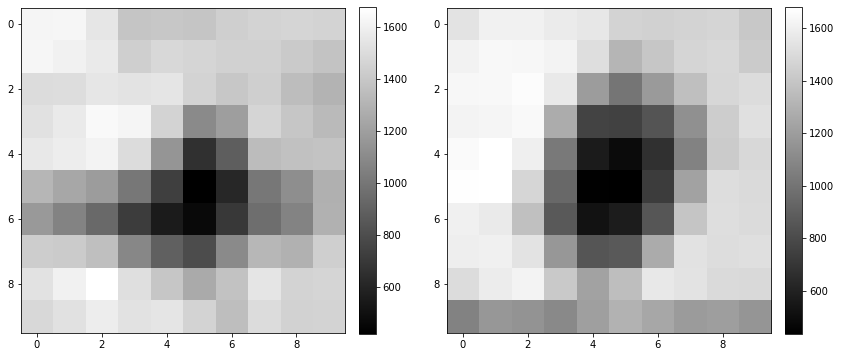

In [138]:
imgplot(snips[0], snips[1], slice_no=[4,4])

In [27]:
#draw ROI on the images and display the results
def draw_roi(image,peaks,r):
    ##Arguments:
    # image : 3D image on which the labelling is needed to be done
    # peaks : array containing the list of local maximas
    # r     : radius of the ROI bounding box
    import os
    import datetime
    from matplotlib import pyplot as plt
    from skimage.draw import rectangle_perimeter
    import matplotlib.patches as mpathches
    cur_path = os.getcwd()
    name = str((datetime.datetime.now()).strftime("%d%m%Y_%H%M%S")) + '.png'
    n = len(peaks)
    grid_n = int(n/2 if n%2 == 0 else ((n+1)/2))
    
    plt.figure(figsize = (12,14))
    for i in range(n):    
        p = peaks[i]
        temp = image[:,:,p[2]]
        plt.subplot(grid_n,2,i+1)
        plt.imshow(temp, cmap = plt.get_cmap('gray'))
        ax = plt.gca()
        rect = mpathches.Rectangle((p[1]-r, p[0]-r), 2*r, 2*r,
                                  fill= False, edgecolor = 'red', linewidth = 1)
        ax.add_patch(rect)
        #ax.set_axis_off()
    plt.tight_layout() 
    plt.savefig(cur_path + '/visuals/stills_2d/' + name)
    plt.show()

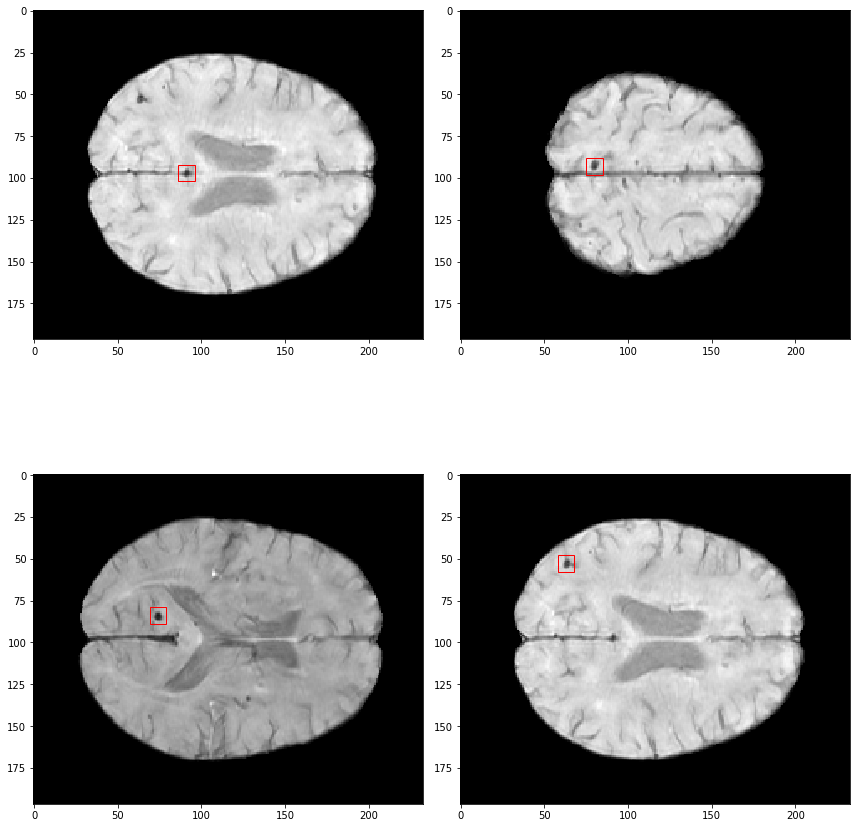

In [43]:
draw_roi(img_pat,peaks,5)

In [56]:
#snip a lot of non-microbleeds images from the subject image by traversing through it
#NOTE: Needs to be made more robest for module mode
def random_snips(image,r, n_snips):
    #Arguments -->
    #image   : 3D array for snipping. (Note: It must be MNI registered.)
    #r       : radius of the snipped image(in pixels)
    #n_snips : no of snips to be generated
    from random import randint
    import numpy as np
    import os
    cur_path = os.getcwd()
    indexes = []
    snips = []
    #import sys, os
    #sys.path.append(os.path.)
    from pfca.core.preprocessing import mni_template_registration
    harvard_mni = mni_template_registration(cur_path,harvard_atlas,'harvard')
    harvard_mask = (harvard_mni.numpy() > 0)*1
    indices = np.asarray(np.where(harvard_mask == 1)).T
    n_indices = len(indices)
    for i in range(n_snips):
        t = randint(0,n_indices)
        tmp_pt = indices[t]
        indexes.append(tmp_pt)
        tmp_snip = image[tmp_pt[0]-r:tmp_pt[0]+r, tmp_pt[1]-r:tmp_pt[1]+r, tmp_pt[2]-r:tmp_pt[2]+r]
        snips.append(tmp_snip)
    return snips, indexes    

In [29]:
rnd_snips, indices = random_snips(img_pat,5,6)

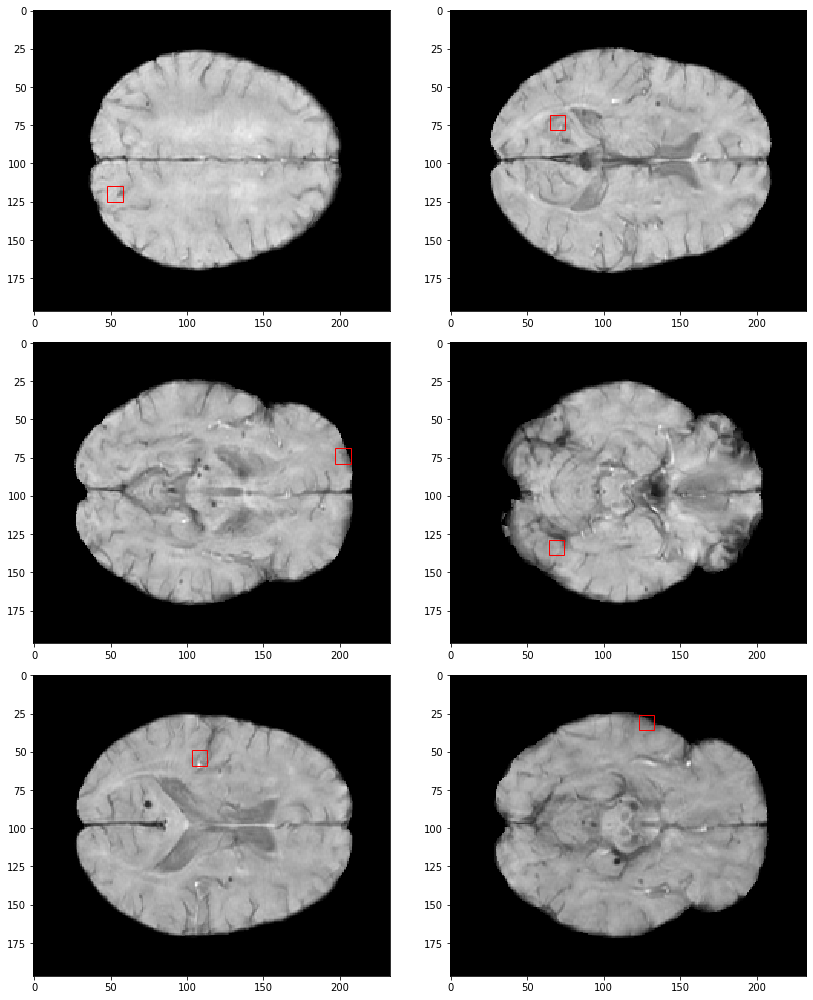

In [59]:
draw_roi(img_pat,indices,5)

In [31]:
#2D visualization using t-SNE, Isomap and PCA for estimating the effectiveness of feature space
#NOTE: Dimensions are reduced across columns
def viz_dimensional(feature_matrix, algo = 'tsne', colormap = None, labelmap = None):
    from matplotlib import pyplot as plt
    import datetime
    import os
    cur_path = os.getcwd()
    name = str((datetime.datetime.now()).strftime("%d%m%Y_%H%M%S")) + 'dimReduction.png'
    if algo == 'tsne':
        from sklearn.manifold import TSNE
        x_embed = TSNE(n_components=2).fit_transform(feature_matrix)
        plt_title = 't-Stochastic Neighbour Embedding(t-SNE) plot'
    elif algo == 'pca':
        from sklearn.decomposition import PCA
        pca = PCA(n_components = 2,svd_solver = 'full')
        x_embed = pca.fit_transform(feature_matrix)
        plt_title = 'Principal Component Analysis(PCA) plot'
    elif algo == 'isomap':
        from sklearn.manifold import Isomap
        x_embed = Isomap(n_components=2).fit_transform(feature_matrix)
        plt_title = 'Isometric Mapping(Isomap) plot'
    elif algo == 'all':
        return
    else:
        print("Error: Some unknown value of algo argument is encountered. Aborting..")
    plt.figure(figsize= (12,8))
    ax =plt.gca()
    scale = np.ones(x_embed.shape[0]) * 100
    print(x_embed.shape)
    if (colormap == None) and (labelmap == None):
        ax.scatter(x_embed[:,0], x_embed[:,1], alpha = 0.3, s = scale)
    elif (colormap != None) and (labelmap != None):
        for ind in list(labelmap.keys()):
            index = ind.split(':')
            ax.scatter(x_embed[int(index[0]):int(index[1]),0], x_embed[int(index[0]):int(index[1]),1], 
                       alpha = 0.3, s = scale, c = colormap[int(index[0]):int(index[1])], label = labelmap[ind])
        ax.legend()
    else:
        print("Error: Either colorlist or label list is missing from the arguments.")
    ax.grid(True)
    plt.title(plt_title)
    plt.savefig(cur_path + '/visuals/stills_2d/' + name)
    #ax.set_axis_off()
    plt.show()                

In [32]:
a = rnd_snips[0].reshape((50,20))

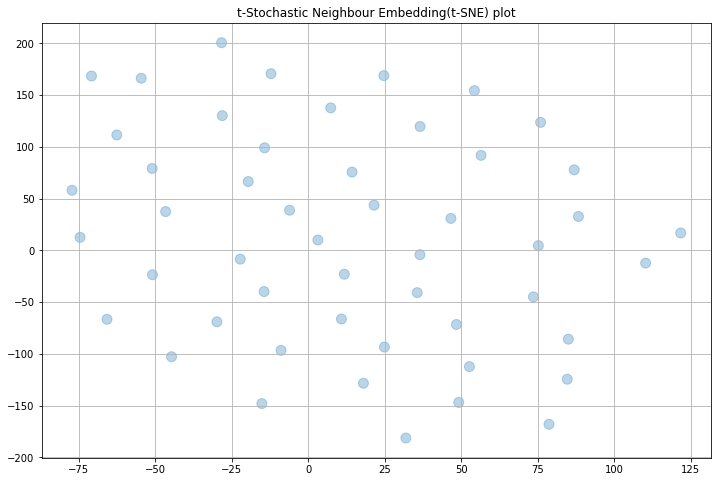

In [31]:
viz_dimensional(a, algo = 'tsne')

In [33]:
#generate colormap for the labels provided
def generate_colormap(array, label, color, c_matrix = None, l_matrix = None):
    #Arguments:
    #array  : just to get the size of the colormap
    #label  : the string label for all the datapoints in the array
    #color  : BGR value of the color where B,G,R are between 0 to 1(correspondingly 0 to 255)
    #matrix : matrix in which the colormap is needed to be appended
    n = array.shape[0]
    c = (color[0], color[1], color[2])
    if type(c_matrix).__name__ == 'NoneType' and type(l_matrix).__name__ == 'NoneType':
        l_matrix = {}
        l_matrix['0:'+str(n-1)] = label
        c_matrix = []
        for i in range(n):
            c_matrix.append(c)
        return c_matrix,l_matrix    
    elif type(c_matrix).__name__ != 'NoneType' and type(l_matrix).__name__ != 'NoneType':
        ind_list = list(l_matrix.keys())[-1]    #getting the last added label into l_matrix
        last_ind = int(ind_list.split(':')[-1]) #Converting the last index to an integer
        new_ind = last_ind + 1
        l_matrix[str(new_ind) + ':' + str(new_ind + n)] = label
        for i in range(n):
            c_matrix.append(c)
        return c_matrix, l_matrix    

In [35]:
#generate feature vector matrix for the visualization purpose
#NOTE: Works only for single snippet
def feature_matgen(data_pt,matrix = None):
    #Aruments:
    #data_pt : multidimensional data point which is to be added to matrix
    #matrix  : feature_matrix in which data_pt will be appended
    if type(matrix).__name__ == 'NoneType':
        feature_matrix = np.ravel(data_pt)
        feature_matrix = np.reshape(feature_matrix, (1,len(feature_matrix)))
        return feature_matrix
    else:
        temp = np.ravel(data_pt)
        if len(temp) != matrix.shape[1]:
            print("Error: The dimensions of matrix and unravelled data point doesn't match. Appending can't be done.")
        else:
            feature_matrix = np.vstack((matrix,temp))
            return feature_matrix

In [41]:
#converting the whole snippet list into a feature matrix
def snip_matrix(snip_list):
    #Arguments:
    #snip_list : list of snipped images 
    feature_matrix = feature_matgen(snip_list[0])
    for i in range(1, len(snip_list)):
        feature_matrix = feature_matgen(snip_list[i], feature_matrix)
    return feature_matrix    

In [38]:
feat = feature_matgen(rnd_snips[2]) #trying feature matrix generator function on a single snippet

In [39]:
feat = feature_matgen(rnd_snips[3],feat) #appending a new single snippet into the last feature matrix

In [42]:
rnd_snps, indices = random_snips(img_pat,5,100)   #generating random snippets from the 3D image
feat = snip_matrix(rnd_snps)                      #converting snippets into a feature matrix

In [43]:
#generating colormap for the visualization
#First, we generate the green color(0,1,0) for the random snippets
colormap,labels = generate_colormap(feat, 'random snips', color = [0,1,0])  

In [44]:
#converting the true detected Cerebral microbleed snippets into feature matrix
snips_mat = snip_matrix(snips)

In [45]:
#Appending the colormap and labelmap with the CMB points which will be in red color for visualization
clrmap, lbls = generate_colormap(snips_mat, 'Cerebral Microbleeds', color = [1,0,0]
                                 , c_matrix = colormap, l_matrix = labels)

In [46]:
#Checking for generated labels...This format of labels will work only in the viz_dimensional() function
lbls

{'0:99': 'random snips', '100:104': 'Cerebral Microbleeds'}

(100, 2)


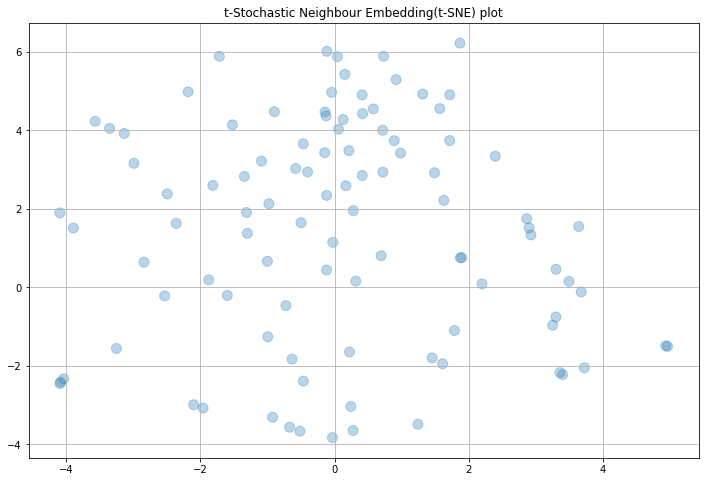

In [47]:
#visualizing only random snippets
viz_dimensional(feat, algo = 'tsne')

In [48]:
#generating the complete feature matrix consisting of all the data points (random snips + CMBs)
cmb_matrix = snip_matrix(snips)
feat_full = np.vstack((feat,cmb_matrix))

(104, 2)


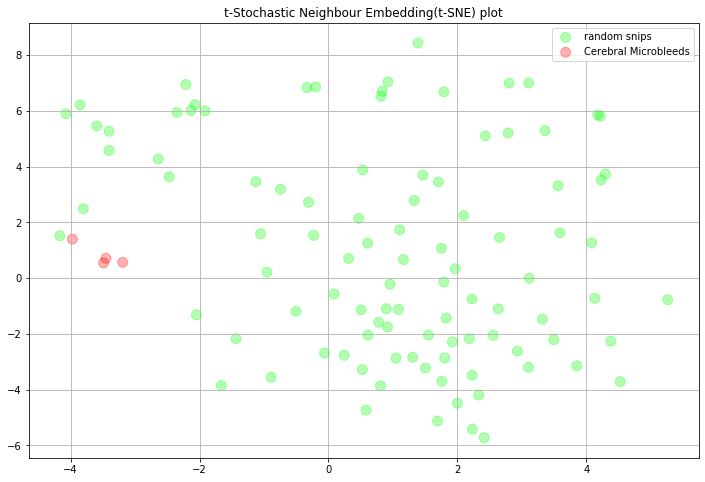

In [102]:
#Visualization of random snippets along with cerebral microbleed snippets
viz_dimensional(feat_full,algo = 'tsne', colormap = clrmap, labelmap = lbls)

(104, 2)


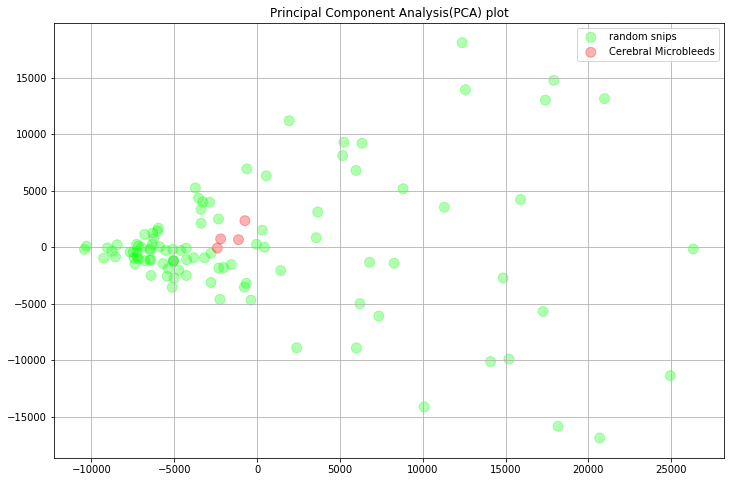

In [49]:
#draw_roi(img_pat, indices[0:6], 5)
viz_dimensional(feat_full,algo = 'pca', colormap = clrmap, labelmap = lbls)

In [50]:
#T2 CSF exclusion from MRI
#def csf_exclusion(image, t2_image):
    

In [60]:
#dataset generation for the semi-supervised classification task
#Here, generating non-targets for the classification
non_targets, indices = random_snips(img_pat,5,1000)

In [66]:
images_arr = np.array(non_targets)
ind = np.array(indices)

In [100]:
def store_dataset(images, labels, name):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    import h5py
    import os
    cur_path = os.getcwd()
    num_images = len(images)
    
    hdf5_dir = cur_path + '/datasets/learning/'
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir + f"{num_images}_" + name + ".h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U16BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U16BE, data=labels
    )
    file.close()
    print("Dataset " + name + " stored Successfully!")

In [101]:
store_dataset(images_arr, ind, 'non_targets')

Dataset non_targets stored Successfully!


In [102]:
def read_hdf_dataset(name):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    import os
    import h5py
    cur_path = os.getcwd()
    images, labels = [], []
    hdf5_dir = cur_path + '/datasets/learning/'
    # Open the HDF5 file
    file = h5py.File(hdf5_dir + f"{name}" + ".h5", "r+")
    return file

In [103]:
non_target_data = read_hdf_dataset('1000_non_targets')

In [108]:
#performing data augmentation for the targets in order to increase their quantity since their number are limited
#

In [109]:
#clustering algorithm for unsupervised step